<a href="https://colab.research.google.com/github/GuoHeyu/COS597D_3D_Reconstrcution/blob/main/gnn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graph Neural Networks with PyTorch Geometric**

[Gage DeZoort](https://github.com/gagedezoort)

Wintersession 2025

Similar examples can be found at https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

Several cells evolved from a notebook created by [Savannah Thais](https://github.com/savvy379).

**Introduction**
This notebook teaches the reader how to build and train Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). The first portion walks through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. Before diving in, let's set up our software environment:

# 0. Software Installation
Just click through the following cells, no need to linger!

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

# check the torch/cuda installations
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.5.1+cu121


Given the current PyTorch/Cuda installations, we'll install [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) as follows:

In [2]:
# install PyTorch Geometric (PyG)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 56.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 1. Graph-Structured Data

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $V$ and their pairwise relationships encoded as edges $E$, i.e. $G=(V,E)$. In the following we will usually denote $|V|=n_\mathrm{nodes}$ and $|E|=n_\mathrm{edges}$. Graphs can easily represent a wide range of structured data including atoms in molecules (nodes=atoms, edges=molecular bonds), users in a social network (nodes=people, edges=social connections), cities and roads in a transportation system (nodes=cities, edges=roads), planetary simulations (nodes=planets, edges=gravitational interactions), and more.

In PyG, graphs are stored as `Data` objects (see the [docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)). Given a graph named `data`, we will find in many cases that it has several of the following attributes:

- `data.x`: node feature matrix of dimension $n_\mathrm{nodes}\times d_V$, where $d_V$ is the number of features attached to each node.
- `data.edge_index`: a sparse edge list in COO format indicating node indices at each end of each edge; this object has size $2\times n_\mathrm{edges}$.
- `data.edge_attr`: edge feature matrix of dimension $n_\mathrm{edges}\times d_E$, where $d_E$ is the number of features attached to each edges.
- `data.y`: training target with arbitary shape (remember, targets may be node-level, edge-level, or graph-level)

##  1.1 Karate Club
Let's take a look at an example graph in PyG. The Zachary Karate Club dataset (1977) is a social network describing friendships in a university karate club:
- 34 nodes (members of the karate club)
- 78 edges (friendships outside of the club)

A conflict arose between an instructor and an adminstrator, causing a faction in the club - half of the members formed a new karate club around the previous instructor and half either found a new instructor or quit karate.
- Truth labels: faction, 0 or 1 (per node)

Note that this is a single graph, and the goal is to perform *node classification* on the training set of nodes (a subset of all the nodes in the graph). In this way, Karate Club is used for semi-supervised node classification.

In [3]:
from torch_geometric.datasets import KarateClub

# KarateClub is a small, easily visualized community graph
karate_club = KarateClub()._data

**Exercise 1.1a**: In the following cell, print the KarateClub object and its attributes, `x`, `edge_index`, `y`.

In [11]:
# EXERCISE
print(karate_club)
print(karate_club.x)
print(karate_club.edge_index)
print(karate_club.y)
print(karate_club.train_mask)


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33

As a brief aside, let's take a look at how PyG stores edges. In a fully connected graph, there are $\frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$ edges. Sparse graphs have relatively few edges, i.e. $n_\mathrm{edges}\ll \frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$. Adjacency matrices aren't necessarily the best way to represent sparse graphs - instead, packages like PyG use edge index lists in COO format.

In [5]:
# edge lists (COO format)
out_nodes = karate_club.edge_index[0]
print('edges move out of the following nodes:\n', out_nodes)
in_nodes = karate_club.edge_index[1]
print('edges move into the following nodes:\n', in_nodes)

edges move out of the following nodes:
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
        31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
edges move into the following nodes:
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
         3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
         1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  

**Exercise 1.1b** Use `torch_geometric.utils.to_dense_adj` to generate an adjacency matrix from `edge_index`.

In [13]:
import torch_geometric
# EXERCISE
adj_mat = torch_geometric.utils.to_dense_adj(karate_club.edge_index)
print(adj_mat)
adj_mat.shape

tensor([[[0., 1., 1.,  ..., 1., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]])


torch.Size([1, 34, 34])

We can print several additional details about the graph:

In [8]:
# more details about the graph
def get_graph_stats(data):
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

get_graph_stats(karate_club)

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Okay, good, we've taken a look at our first instance of `Data`. Now let's visualize the graph; note that here it has 4 truth labels instead of 2, which have been generated by a graph clustering algorithm (if you're interested see [this ref](https://ieeexplore.ieee.org/document/4358966), but it's not important here). We'll use `networkx`, a networks dynamics software package, to visualize the graph.

Truth labels tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


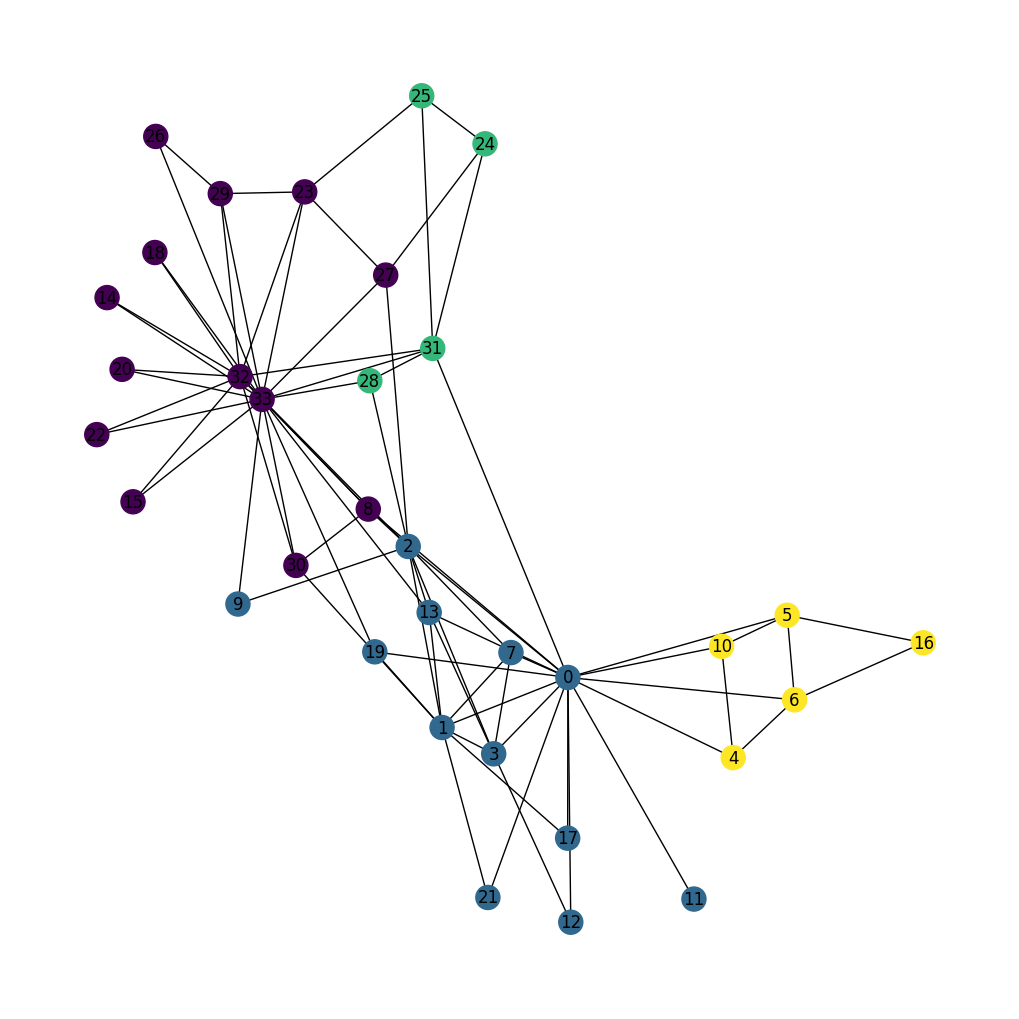

In [9]:
import torch_geometric
import networkx as networkx
print('Truth labels', karate_club.y)
karate_club_nx = torch_geometric.utils.to_networkx(karate_club, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw(karate_club_nx, with_labels=True, node_color=karate_club.y)

## 1.2 ENZYMES Graphs

Karate Club is used for semi-supervised node classification; let's look at a dataset used for graph-level classification. The [ENZYMES dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html#torch_geometric.datasets.TUDataset)
contains 600 graphs representing proteins with ~32.6 nodes (secondary structure elements - helices, turns or sheets) and ~124.3 edges (denoting neighbors in space or in the amino acid sequence) each. For expert details see the [TUDataset paper](https://arxiv.org/pdf/2007.08663.pdf). The goal is to assign each protein to one of 6 enzyme commission numbers, which describe the chemical reaction the enzyme catalyzes.

In [10]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
dataset.data

Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[19580, 21], edge_index=[2, 74564], y=[600])

For PyG `datasets` containing multiple graphs, you'll typically want to use a `DataLoader` to load up batches of graphs:

In [12]:
from torch_geometric.loader import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loader = DataLoader(dataset, batch_size=32, shuffle=False)
for batch in loader:
  print(batch)

DataBatch(edge_index=[2, 4264], x=[1069, 21], y=[32], batch=[1069], ptr=[33])
DataBatch(edge_index=[2, 3444], x=[972, 21], y=[32], batch=[972], ptr=[33])
DataBatch(edge_index=[2, 3848], x=[976, 21], y=[32], batch=[976], ptr=[33])
DataBatch(edge_index=[2, 4026], x=[1099, 21], y=[32], batch=[1099], ptr=[33])
DataBatch(edge_index=[2, 2560], x=[669, 21], y=[32], batch=[669], ptr=[33])
DataBatch(edge_index=[2, 4428], x=[1105, 21], y=[32], batch=[1105], ptr=[33])
DataBatch(edge_index=[2, 4434], x=[1145, 21], y=[32], batch=[1145], ptr=[33])
DataBatch(edge_index=[2, 3614], x=[911, 21], y=[32], batch=[911], ptr=[33])
DataBatch(edge_index=[2, 4144], x=[1096, 21], y=[32], batch=[1096], ptr=[33])
DataBatch(edge_index=[2, 5558], x=[1654, 21], y=[32], batch=[1654], ptr=[33])
DataBatch(edge_index=[2, 3538], x=[927, 21], y=[32], batch=[927], ptr=[33])
DataBatch(edge_index=[2, 3192], x=[845, 21], y=[32], batch=[845], ptr=[33])
DataBatch(edge_index=[2, 3582], x=[926, 21], y=[32], batch=[926], ptr=[33])


**Exercise 1.1c**: Notice also that the data batches appear to have concatenate the nodes and edges of all the graphs into a single "batch graph." How does this work? (Hint: look at the `batch` attribute appended to each batch.)

In [16]:
# EXERCISE
print(batch.batch)
batch.batch.shape



tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6, 

torch.Size([899])

# 2. Graph Neural Networks

In general, GNNs work by leveraging local information across the graph structure to intelligently compute new features for the nodes (and/or edges). A commonly used class of GNNs is the Graph Convolutional Network (GCN). GCNs use more-or-less the same convolution operations you've seen used in convolutional neural networks; however, instead of applying them to patches of images, they apply them to node neighborhoods. "Messages" are computed from each of a node's neighbors, and these messages are "passed" back to the node and used to update its features. We're going to make this painfully concrete; first, here's a schematic:

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

## 2.1 Graph Convolutional NNs

Let's look at a graph convolutional network (GCN) as originally posed in [Semi-Supervised Classification with Graph Convolutional Networks
](https://arxiv.org/pdf/1609.02907.pdf). Don't worry if the details aren't super clear, we'll highlight the most important things to remember.

Fix a graph with node features stacked into a matrix $\mathbf{X}^{(0)}\in\mathbb{R}^{n_\mathrm{nodes}\times d_V}$ and an adjacency matrix $\mathbf{A} \in [0,1]^{n_\mathrm{nodes}\times n_\mathrm{nodes}}$. A GCN will repeatedly apply graph convolutions to come up with new hidden representations of each node $\mathbf{X}^{(\ell)}$, where $\ell$ counts how many GCN layers you've applied. The forward pass of a GCN is based on message passing by taking a weighted average over each node's neighborhood. The weighted average is performed using a matrix $\mathbf{P}$ that is constructed from $\mathbf{A}$ - it is the symmetric degree-normalized adjacency matrix with self-loops - so that given a matrix $\mathbf{W}^{(\ell+1)}$ of trainable weights (no biases!) the GCN forward pass looks like this:

- GCN Forward Pass:
$$
\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}
$$

Here, $\sigma$ is any non-linearity (activation function).
This forward pass should look pretty familiar! It's just like the forward pass of a feedforward NN applied to each node, where we're mixing up the node features by multiplying with $\mathbf{P}$ - this is neural message passing. Let's compare:

- DNN:
$$\mathbf{x}^{(\ell+1)} = \sigma(\mathbf{x}^{(\ell)})\mathbf{W}^{(\ell+1)}$$
- GCN:  
$$\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$


We can re-cast the GCN matrix equation in terms of our familiar message-passing notation:

$$
\mathbf{x}_v^{(\ell + 1)} = \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

Here, $c_{w,v}$ refers to a fixed normalization coefficient for each edge; in the original formulation, $c(w,v)=\sqrt{\big((deg(w)+1)(deg(v)+1)\big)}$. This should make it clear that $\mathbf{P}$ simply computes a weighted sum of the neighborhood features for each node.

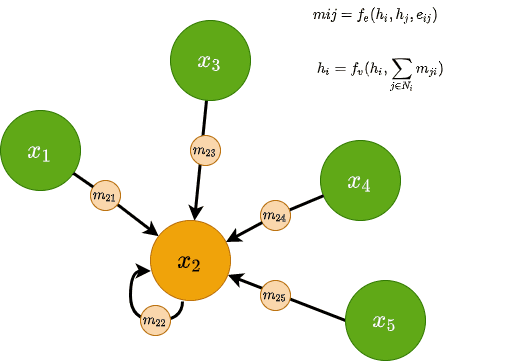

### Calculating the P Matrix for Karate Club
I should emphasize: $\mathbf{P}$ depends on the dataset you're looking at! I.e. message passing is dependent on the structure of your graph. Far-away nodes may never share information, but close-by nodes will do a lot of mixing. Here's an example of how you can compute the GCN message passing operator $\mathbf{P}$ for Karate Club:

In [17]:
# we'll use matrix notation to make it clear what's happening:
A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
A_tilde = A + torch.eye(A.shape[0])
sqrt_node_degrees = torch.sqrt(torch.sum(A_tilde, dim=1))
D_tilde_inv = torch.diag(1/sqrt_node_degrees)

# P specifies our degree-normalized neighborhood sums
P = D_tilde_inv @ A_tilde @ D_tilde_inv
print(P)
print(P.shape)

tensor([[0.0588, 0.0767, 0.0731,  ..., 0.0917, 0.0000, 0.0000],
        [0.0767, 0.1000, 0.0953,  ..., 0.0000, 0.0000, 0.0000],
        [0.0731, 0.0953, 0.0909,  ..., 0.0000, 0.0836, 0.0000],
        ...,
        [0.0917, 0.0000, 0.0000,  ..., 0.1429, 0.1048, 0.0891],
        [0.0000, 0.0000, 0.0836,  ..., 0.1048, 0.0769, 0.0654],
        [0.0000, 0.0000, 0.0000,  ..., 0.0891, 0.0654, 0.0556]])
torch.Size([34, 34])


This is the thing that's going to facilitate our message passing! I.e. messages from node 1 to node 1 will be weighted by 0.0588, messages from node 2 to node 1 will be weighted by 0.0767, etc.

## 2.2 Cora (Karate Club but bigger!)

We will now use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The learning task is the same as it was with Karate Club, semi-supervised node classification. The Cora dataset consists of

- 2,708 nodes (scientific papers)
- 7 truth classes (paper subjects)
- 5,429 edges (representing citations)
- 1,433 node features (each a binary field indicating the presence of a word in the corresponding paper)

Let's go!

In [18]:
# import the cora citation network
from torch_geometric.datasets import Planetoid
cora_dataset = Planetoid(root='data/Planetoid', name='Cora')

Processing...
Done!


In [19]:
# there is only one graph in this dataset
cora = cora_dataset[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**Exercise 2.2a** Print out the train, val, and test masks. How many nodes are we training with? How could this affect the prediction task?

In [23]:
# EXERCISE
print(cora.train_mask.sum())
print(cora.val_mask.sum())
print(cora.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


In [24]:
# use our previous function to inspect Cora
get_graph_stats(cora)

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


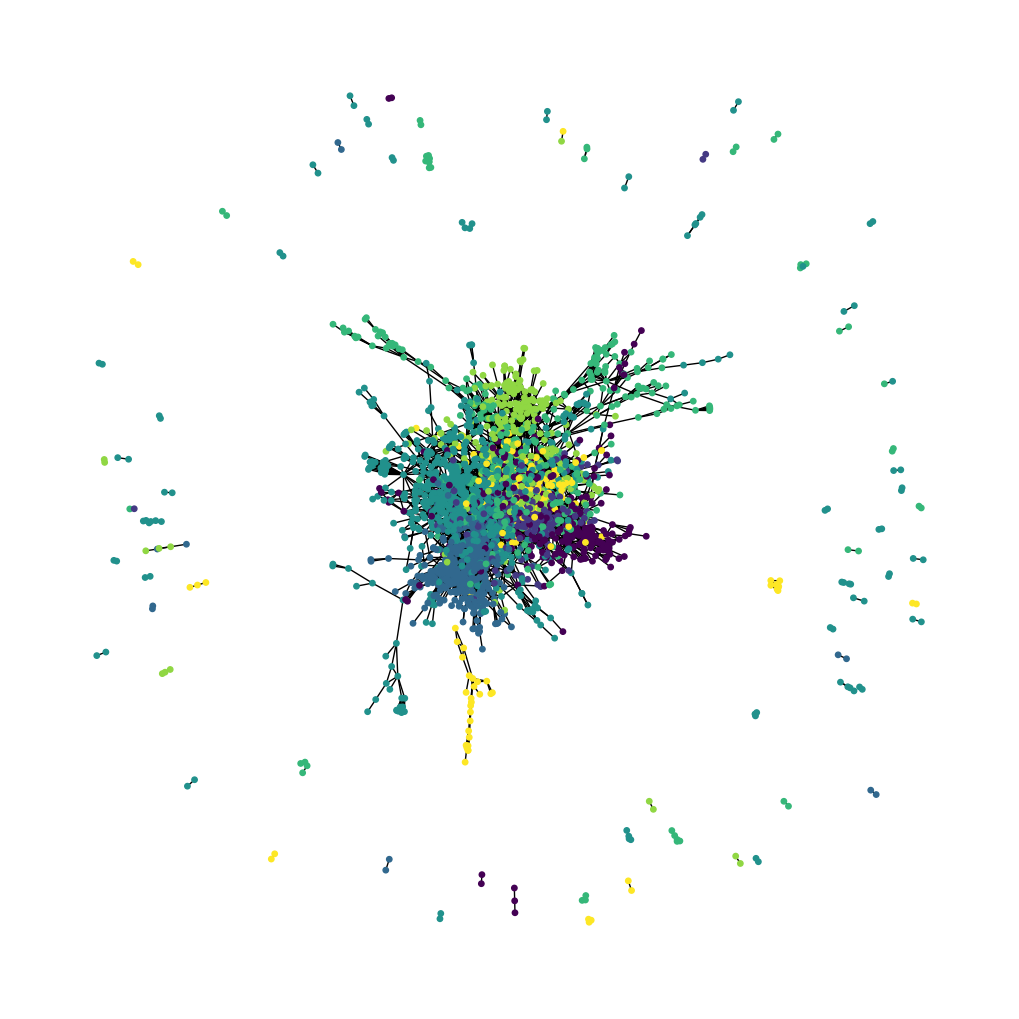

In [25]:
# let's visualize the graph
plt.figure(figsize=(10,10))
cora_nx = torch_geometric.utils.to_networkx(cora, to_undirected=True)
nx.draw(cora_nx, node_size=15, node_color=cora.y)

Okay, now it's time to set up a GCN using PyG! Reminder: we can construct a GNN in PyG similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's `GCNConv` implementing the graph convolution:

$$
\mathbf{x}_v^{(\ell + 1)} =  \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

In [26]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        return x

This GCN is very similar to the [original implementation](https://github.com/tkipf/pygcn).

Let's take a look at the predictions of an untrained GCN by looking at a low dimensional representation:

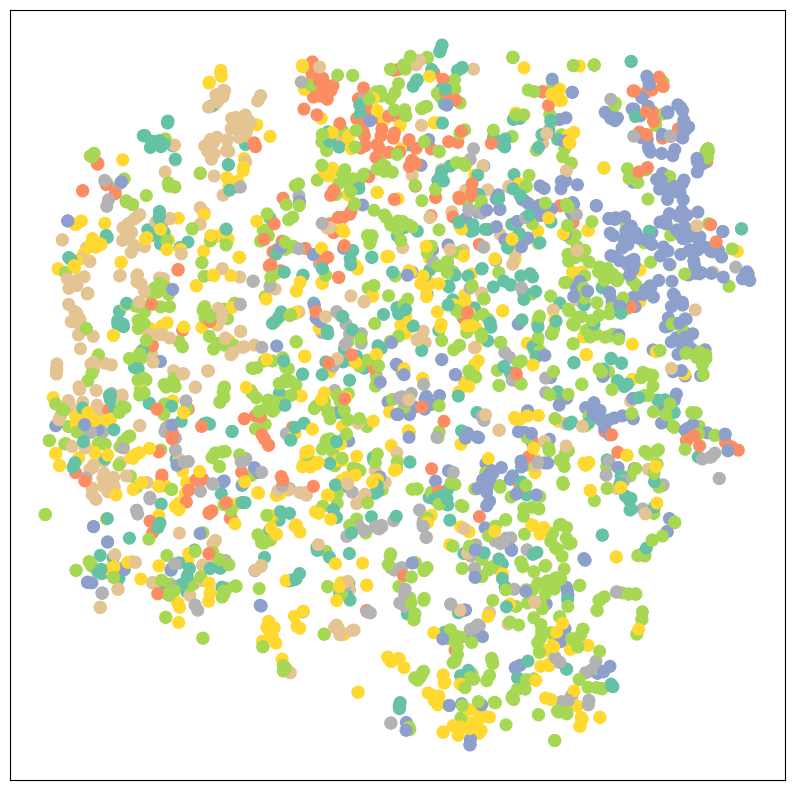

In [27]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# examine the output of an untrained GCN
model = GCN()
model.eval()
out = model(cora)
visualize(out, color=cora.y)

Doesn't look like much, right? I guess we need to teach the GCN what to do!

In [28]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9480
Epoch: 002, Loss: 1.8572
Epoch: 003, Loss: 1.7427
Epoch: 004, Loss: 1.5972
Epoch: 005, Loss: 1.4579
Epoch: 006, Loss: 1.3265
Epoch: 007, Loss: 1.2156
Epoch: 008, Loss: 1.0998
Epoch: 009, Loss: 0.9571
Epoch: 010, Loss: 0.8527
Epoch: 011, Loss: 0.7690
Epoch: 012, Loss: 0.6826
Epoch: 013, Loss: 0.5832
Epoch: 014, Loss: 0.5279
Epoch: 015, Loss: 0.4569
Epoch: 016, Loss: 0.4202
Epoch: 017, Loss: 0.3636
Epoch: 018, Loss: 0.3494
Epoch: 019, Loss: 0.3148
Epoch: 020, Loss: 0.2628
Epoch: 021, Loss: 0.2189
Epoch: 022, Loss: 0.2200
Epoch: 023, Loss: 0.1930
Epoch: 024, Loss: 0.1869
Epoch: 025, Loss: 0.1644
Epoch: 026, Loss: 0.1466
Epoch: 027, Loss: 0.1348
Epoch: 028, Loss: 0.1099
Epoch: 029, Loss: 0.1055
Epoch: 030, Loss: 0.1070
Epoch: 031, Loss: 0.1258
Epoch: 032, Loss: 0.0974
Epoch: 033, Loss: 0.0825
Epoch: 034, Loss: 0.0805
Epoch: 035, Loss: 0.0724
Epoch: 036, Loss: 0.0764
Epoch: 037, Loss: 0.0767
Epoch: 038, Loss: 0.0587
Epoch: 039, Loss: 0.0744
Epoch: 040, Loss: 0.0547


In [29]:
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7960


Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



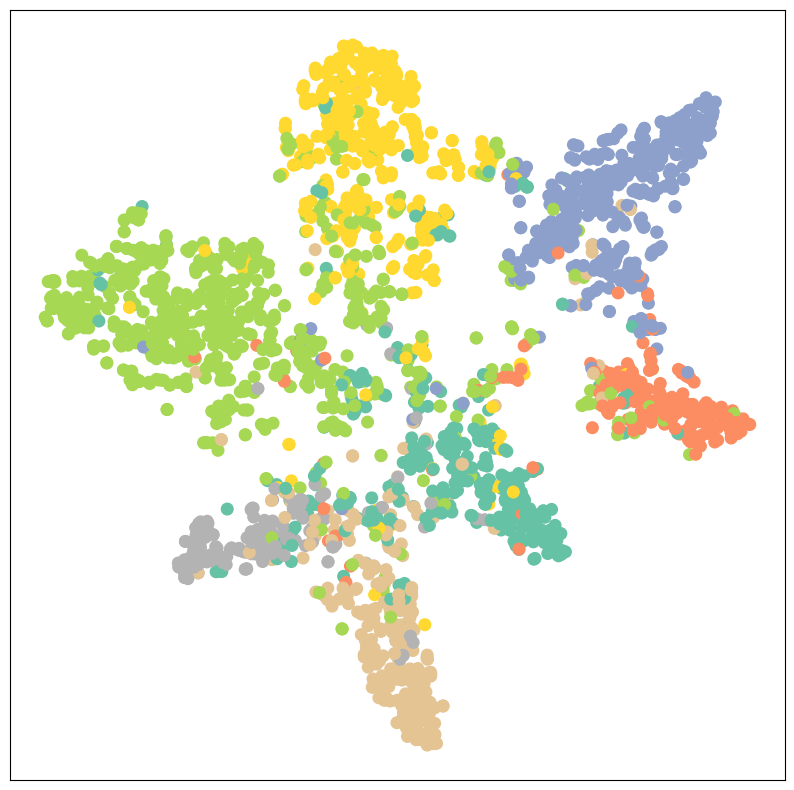

In [30]:
model.eval()

out = model(cora)
visualize(out, color=cora.y)

**Exercise 2.2b** Play around with the training loop above! Some guiding questions:

- How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

- So far, we've just looked at GCNConv operations. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all GCNConv instances with GATConv layers that make use of attention? Try to write a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a dropout ratio of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head.

In [43]:
# EXERCISE
class GCN_test1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        return x

class GCN_test2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv3(x, edge_index) # output graph embedding

        return x

model = GCN_test1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

model = GCN_test2()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9340
Epoch: 002, Loss: 1.8215
Epoch: 003, Loss: 1.6978
Epoch: 004, Loss: 1.5564
Epoch: 005, Loss: 1.4013
Epoch: 006, Loss: 1.2693
Epoch: 007, Loss: 1.1190
Epoch: 008, Loss: 1.0129
Epoch: 009, Loss: 0.8914
Epoch: 010, Loss: 0.8129
Epoch: 011, Loss: 0.7247
Epoch: 012, Loss: 0.6110
Epoch: 013, Loss: 0.5954
Epoch: 014, Loss: 0.5205
Epoch: 015, Loss: 0.4575
Epoch: 016, Loss: 0.4478
Epoch: 017, Loss: 0.3569
Epoch: 018, Loss: 0.3455
Epoch: 019, Loss: 0.2845
Epoch: 020, Loss: 0.3009
Epoch: 021, Loss: 0.2168
Epoch: 022, Loss: 0.2156
Epoch: 023, Loss: 0.1748
Epoch: 024, Loss: 0.1587
Epoch: 025, Loss: 0.1478
Epoch: 026, Loss: 0.1226
Epoch: 027, Loss: 0.1233
Epoch: 028, Loss: 0.1129
Epoch: 029, Loss: 0.1381
Epoch: 030, Loss: 0.1308
Epoch: 031, Loss: 0.1191
Epoch: 032, Loss: 0.0834
Epoch: 033, Loss: 0.0757
Epoch: 034, Loss: 0.0799
Epoch: 035, Loss: 0.0868
Epoch: 036, Loss: 0.0498
Epoch: 037, Loss: 0.0784
Epoch: 038, Loss: 0.0680
Epoch: 039, Loss: 0.0782
Epoch: 040, Loss: 0.0832


In [ ]:
# EXERCISE




In [ ]:
# EXERCISE




# 3. Graph-Level Training with ENZYMES (Long Exercise)
We've spent a lot of time on semi-supervised node classification, but what about graph classication in the sprit of the ENZYMES dataset? In this case, we don't want per-node outputs; we want one output vector per graph, giving the probabilities that the graph (enzyme) belongs to one of the classes (catalyst scores). Our GCN currently outputs 1 vector per node - we can *pool* these vectors, for example by averaging them, to produce 1 output vector for each graph. Once we normalize the output with `log_softmax`, it will represent classification scores for the entire graph. Here's your goal; modify the GCN above using [PyG global mean pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html) and re-train the GCN to predict classification scores on the ENZYMES dataset. The following cells will guide you through this:

In [ ]:
# let's re-load the dat
enzymes = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
train_loader = DataLoader(enzymes[:400], batch_size=32, shuffle=True)
test_loader = DataLoader(enzymes[400:], shuffle=False)

**Exercise 3a**: Apply `global_mean_pool` to `x`, fill in the proper dimensions for the convolution layers.


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.pool import global_mean_pool

class PoolingGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # EXERCISE: add the correct input and output dimensions:
        self.conv1 = GCNConv(, 512, cached=False)
        self.conv2 = GCNConv(512, , cached=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        #x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        # EXERCISE: global mean pool x

        return F.log_softmax(x, dim=1)

**Exercise 3b**: Here we've modified the training loop so that you can train your model. Modify the test loop similarly and evaluate the model's performance on the test set.



In [ ]:
model = PoolingGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train_step(train_loader):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss

def test_step(test_loader):
    model.eval()
    # EXERCISE: write a test step and evaluate your model

for epoch in range(1, 101):
    train_loss = train_step(train_loader)
    if not epoch%10:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}')

# 4. Message Passing Under the Hood (Optional)
You may be wondering how the PyG implementation of the GCN compares to our $\mathbf{P}$ matrix aggregations above. Well, according to the [docs](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv),

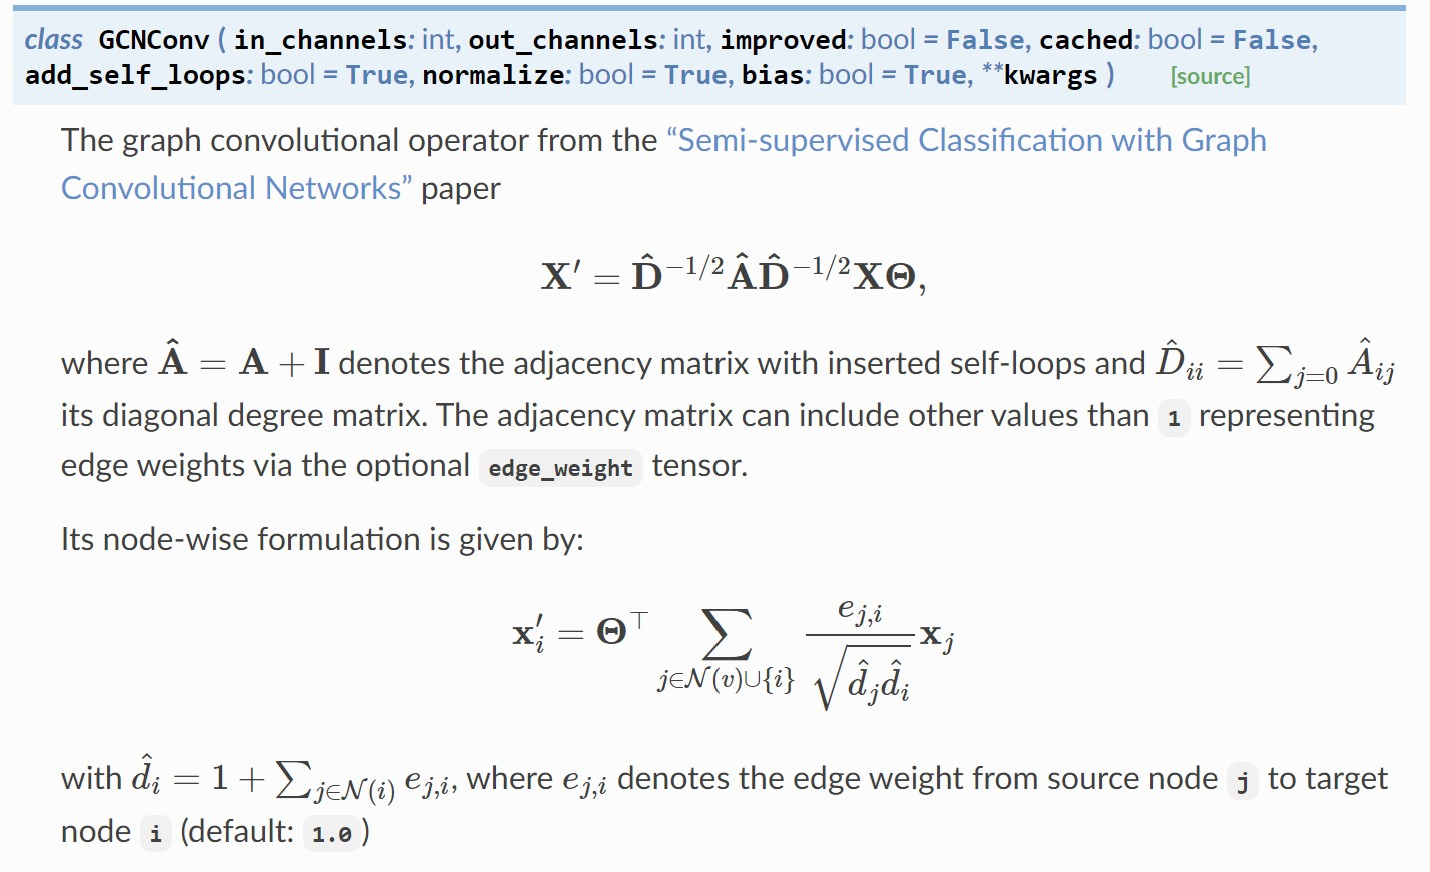

This is exactly the matrix equation we looked at above! Let's see how the PyG implementation works using a simplified version of the default code (https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gcn_conv.html#GCNConv):

In [ ]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch_scatter import scatter_add

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, PairTensor
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

def gcn_norm(edge_index, num_nodes=None,
             add_self_loops=True, dtype=None):

    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                              device=edge_index.device)
    edge_index, edge_weight = add_remaining_self_loops(
        edge_index, edge_weight, 1, num_nodes)

    #
    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

class SimpleGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels,
                 add_self_loops = True,  **kwargs):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index,):
        edge_index, edge_weight = gcn_norm(
            edge_index, x.size(self.node_dim),
            self.add_self_loops
        )
        x = self.lin(x)
        out = self.propagate(
            edge_index, x=x, edge_weight=edge_weight, size=None
        )
        return out

    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j

Let's step back to the KarateClub dataset and see how this `gcn_norm` function works:

In [ ]:
edge_index, edge_weight = gcn_norm(
    karate_club.edge_index,
    num_nodes=karate_club.num_nodes,
    add_self_loops=True
  )
print(edge_weight)

Do these look familiar? These are just the entries of $\mathbf{P}$ corresponding to each edge! For example:

In [ ]:
# check a few examples
def check_edge(idx):
  print(f'\nChecking edge #{idx}')
  out_node, in_node = edge_index[:,idx]
  print(f'...edge extends from {out_node} to {in_node}')
  print(f'...corresponding entry in P: {P[out_node, in_node]}')
  print(f'...corresponding entry in edge_weights: {edge_weight[idx]}')

check_edge(29)
check_edge(3)
check_edge(0)

Evidently, PyG computes the exact same matrix $\textbf{P}$ and maps it onto an edge weight vector `edge_weight`$\in\mathbb[0,1]^{2\times|E|}$. Instead of multiplying matrices, PyG keeps track of edge lists and uses element-wise indexing/multiplication.

So, we get the right normalization. That's great! Now how do we compute a message passing iteration without matrix multiplication by $\mathbf{P}$?

Let's look at the forward pass:

```
def forward(self, x, edge_index,):
    edge_index, edge_weight = gcn_norm(  
        edge_index, x.size(self.node_dim),
        self.add_self_loops
    )
    x = self.lin(x)
    out = self.propagate(
        edge_index, x=x, edge_weight=edge_weight, size=None
    )
    return out  
```

In the first lines we call the `normalize` function to build the $\mathbf{P}$ matrix in the form of `edge_weights`. That checks out!

$$ \texttt{edge_weights}\ \leftrightarrow\ \mathbf{P}$$

Next, we apply a learnable linear transform to our input feature, which is $\sigma(X^{(\ell)})$ from the previous hidden layer.

$$ \texttt{x = self.lin(x)}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)}=\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$

We then call `self.propagate`, which initiates message passing under the hood. This is a PyG convention; whenever `propagate` is called, pairs of nodes ($\mathbf{x}_i, \mathbf{x}_j$) connected by an edge in `edge_index` are formed and passed through the user-defined `message` function. Here, we've defined:

```
def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j
```

As we saw above, each message from node $j$ to node $i$ is just $\frac{1}{c_{j,i}} \cdot \mathbf{x}_j^{(\ell)}$, where $c_{j,i}=\sqrt{\text{deg}(j)+1}\sqrt{\text{deg}(i)+1}$ is the normalization constant in $\mathbf{P}$ (`edge_weight`).

Finally, PyG calls `aggregate` based on the user's choice of aggregation function. Since the GCN aggregation strategy is matrix multiplication, we're using `add` aggregation. We set this as a default kwarg in the `SimpleGCNConv` class. The PyG message passing `update` function updates the state of each node based on these aggregated messages (in general by applying another NN to them, but here we simply take the sum).

$$ \texttt{message}, \texttt{aggregate} \leftrightarrow\ \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$
$$ \texttt{update}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$


Schematically, based on https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html

```
from torch_scatter import scatter

x = ...           # Node features of shape [num_nodes, num_features]
edge_index = ...  # Edge indices of shape [2, num_edges]
edge_weight = ... # Edge weights of shape [1, num_edges]

x_j = x[edge_index[0]]  # Source node features [num_edges, num_features]
x_i = x[edge_index[1]]  # Target node features [num_edges, num_features]

msg = edge_weight.view(-1,1) * x_j  # Compute message for each edge

# Aggregate messages based on target node indices
out = scatter(msg, edge_index[1], dim=0, dim_size=x.size(0), reduce="add")
```


# Wrap Up
Nice! We've used PyG to build an effective GNN that re-embeds the initial Cora dataset graph into a space more useful for node label prediction. We've also gone pretty deep into how neural message passing works with a GCN, in addition to its implementation in PyG. This is a just one of the many available GNN architectures and only one of the possible graph prediction tasks; other common tasks include edge classification and graph classification (check out this tutorial), among others.

In [ ]:
# answers to exercises:

# Exercise 1.1a
# print(karate_club.x)
# print(karate_club.edge_index)
# print(karate_club.y)

# Exercise 1.1b
# A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
#print('adjacency representation', A)

# Exercise 1.1c
# Batching in PyG works by concatenating nodes and creating a block diagonal adacency matrix.
# Membership is tracked through the `batch` attribute appended to each graph batch.
# See: https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html

# Exercise 2.2a
# sum(cora.train_mask)
# There are 140 training nodes, 20 from each of the 7 truth classes.
# This means overtraining is a real possibility and regularization will be important.

# Exercise 2.2b
# Adding more layers doesn't help too much (and even hurts if the network becomes too deep)!
# This is because node features get "washed out" across the graph.

# Exercise 3a
# 21 input features, 6 output classes
# x = global_mean_pool(x, data.batch)

# Exercise 3b
# Just copy the train loop structure and the accuracy metric from the Cora train loop.
# But remember accuracy is computed per-graph now!